In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [2]:
df = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
from sklearn.model_selection import train_test_split

def preprocess_data(df):
    class0_df = df[df['Class'] == 0] ## majority class, will be used for autoencoder training
    class1_df = df[df['Class'] == 1]
    ##
    class0_arr = class0_df.to_numpy()[:, 1:-1] ## feature set from V1 to Amount (Time is excluded)
    class1_arr = class1_df.to_numpy()[:, 1:-1]
    X = class0_arr
    X_train, X_test = train_test_split(X, test_size=0.1)
    X_train, X_val = train_test_split(X_train, test_size=0.1)

    scale_mean = np.mean(X_train, axis=0)
    scale_std = np.std(X_train, axis=0)
    ## normalization
    X_train = (X_train - scale_mean)/scale_std
    X_val = (X_val - scale_mean)/scale_std
    X_test = (X_test - scale_mean)/scale_std
    class1_arr = (class1_arr - scale_mean)/scale_std
    return X_train, X_val, X_test, scale_mean, scale_std, class1_arr

In [5]:
X_train, X_val, X_test, scale_mean, scale_std, class1_arr = preprocess_data(df)
n_features = X_train.shape[1]

In [6]:
n_features

29

<AxesSubplot:>

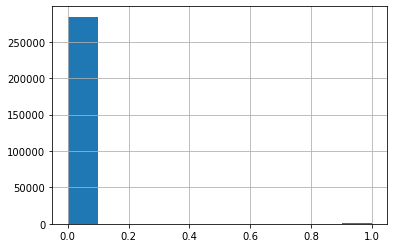

In [7]:
df.Class.hist()

In [8]:
print("Train Size: {}".format(len(X_train)))
print("Val Size: {}".format(len(X_val)))
print("Test Size: {}".format(len(X_test)))
print("No of Features: {}".format(n_features))

Train Size: 230294
Val Size: 25589
Test Size: 28432
No of Features: 29


## AutoEncoder

In [9]:
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import numpy as np

In [10]:
# model archticeture

def build_model():
    model = keras.Sequential([
        keras.Input(shape=(n_features,)),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.BatchNormalization(),
        
        keras.layers.Dense(32, activation='relu'),
        keras.layers.BatchNormalization(),
        
        keras.layers.Dense(16, activation='relu'),
        keras.layers.BatchNormalization(),
        
        keras.layers.Dense(32, activation='relu'),
        keras.layers.BatchNormalization(),
        
        keras.layers.Dense(64, activation='relu'),
        keras.layers.BatchNormalization(),
        
        keras.layers.Dense(n_features)
    ])
    
    return model

In [11]:
# model building
model = build_model()

In [12]:
# model compile
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='mse', metrics=['accuracy'])

In [13]:
# callbacks defined

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 5
    lrate = initial_lrate * (drop**((1 + epoch)/epochs_drop))
    return lrate

lrate_scheduler = LearningRateScheduler(step_decay)
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model_chkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# model fitting
model.fit(X_train, X_train, batch_size=32, epochs=50, validation_data=(X_val, X_val), callbacks=[early_stop, model_chkpoint, lrate_scheduler])

Epoch 1/50
7197/7197 [==============================] - 38s 5ms/step - loss: 0.6398 - accuracy: 0.3847 - val_loss: 0.1677 - val_accuracy: 0.7714

Epoch 00001: val_loss improved from inf to 0.16768, saving model to best_model.h5
Epoch 2/50
7197/7197 [==============================] - 36s 5ms/step - loss: 0.2165 - accuracy: 0.6466 - val_loss: 0.1295 - val_accuracy: 0.8076

Epoch 00002: val_loss improved from 0.16768 to 0.12945, saving model to best_model.h5
Epoch 3/50
7197/7197 [==============================] - 36s 5ms/step - loss: 0.1816 - accuracy: 0.6599 - val_loss: 0.1114 - val_accuracy: 0.8371

Epoch 00003: val_loss improved from 0.12945 to 0.11142, saving model to best_model.h5
Epoch 4/50
7197/7197 [==============================] - 36s 5ms/step - loss: 0.1629 - accuracy: 0.6694 - val_loss: 0.1049 - val_accuracy: 0.8377

Epoch 00004: val_loss improved from 0.11142 to 0.10487, saving model to best_model.h5
Epoch 5/50
7197/7197 [==============================] - 36s 5ms/step - loss:

In [23]:
# Evaluation - If reconstruction loss is greater than a certain threshold, we classify that as fraud class.

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.metrics import precision_recall_curve, roc_curve


def reconstruction_error(actual, pred):
    return np.mean((actual - pred)**2, axis=1)

def evaluate(model, X, y):
    X = X.reshape(-1, n_features)
    out = reconstruction_error(X, model.predict(X))
    print("AUC score: {}".format(roc_auc_score(y, out)))
    print("PR score: {}".format(average_precision_score(y, out)))
    print("\n\n")
    for th in [0.5, 0.6, 0.7, 0.8, 0.9, 1., 1.1 , 1.2, 1.3, 1.4, 1.5, 1.75, 2, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4]:
        out_th = [1 if (o > th) else 0 for o in out]
        print("TH - {}".format(th))
        print("Precision: {}".format(precision_score(y, out_th)))
        print("Recall: {}".format(recall_score(y, out_th)))
        print("F1score: {}".format(f1_score(y, out_th)))
        print("\n\n")
    

In [24]:
final_X_test = np.concatenate((X_test, class1_arr))
final_Y_test = np.concatenate(([0]*len(X_test), [1]*len(class1_arr)))

In [25]:
# Metrics
evaluate(model, final_X_test, final_Y_test)

AUC score: 0.944731345878456
PR score: 0.8010290567637871



TH - 0.5
Precision: 0.6440129449838188
Recall: 0.8089430894308943
F1score: 0.7171171171171171



TH - 0.6
Precision: 0.7160940325497287
Recall: 0.8048780487804879
F1score: 0.7578947368421052



TH - 0.7
Precision: 0.7674418604651163
Recall: 0.8048780487804879
F1score: 0.7857142857142858



TH - 0.8
Precision: 0.8065843621399177
Recall: 0.7967479674796748
F1score: 0.801635991820041



TH - 0.9
Precision: 0.8405172413793104
Recall: 0.7926829268292683
F1score: 0.8158995815899582



TH - 1.0
Precision: 0.8606194690265486
Recall: 0.790650406504065
F1score: 0.8241525423728814



TH - 1.1
Precision: 0.8781609195402299
Recall: 0.7764227642276422
F1score: 0.8241639697950377



TH - 1.2
Precision: 0.8931116389548693
Recall: 0.7642276422764228
F1score: 0.823658269441402



TH - 1.3
Precision: 0.8977556109725686
Recall: 0.7317073170731707
F1score: 0.8062709966405375



TH - 1.4
Precision: 0.904639175257732
Recall: 0.7134146341463414
F1sc

In [26]:
import matplotlib.pyplot as plt
out = reconstruction_error(final_X_test, model.predict(final_X_test))

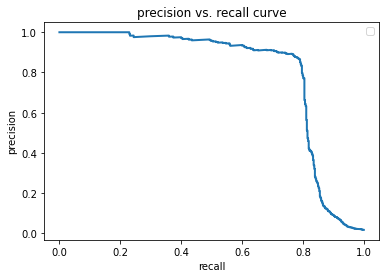

In [27]:
precision, recall, _ = precision_recall_curve(final_Y_test, out)
plt.plot(recall, precision, lw=2)
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

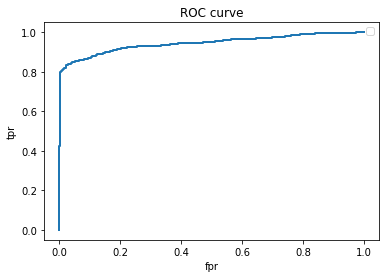

In [29]:
fpr, tpr, _ = roc_curve(final_Y_test, out)
                        
plt.plot(fpr, tpr, lw=2)
    
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend(loc="best")
plt.title("ROC curve")
plt.show()